# **Text Summarization using Seq2Seq based model**


In [45]:
!pip install mlnotify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**importing required libraries**

In [47]:
import numpy as np   #Package for scientific computing and dealing with arrays
import pandas as pd  #Package providing fast, flexible and expressive data structures
import re            #re stands for RegularExpression providing full support for Perl-like Regular Expressions in Python
from bs4 import BeautifulSoup   #Package for pulling data out of HTML and XML files
from keras.preprocessing.text import Tokenizer  #For tokenizing the input sequences
from keras_preprocessing.sequence import pad_sequences
#from keras.preprocessing.sequence import pad_sequences  #For Padding the seqences to same length
from nltk.corpus import stopwords   #For removing filler words
from tensorflow.keras.layers import Input, LSTM, Attention, Embedding, Dense, Concatenate, TimeDistributed   #Layers required to implement the model
from tensorflow.keras.models import Model  #Helps in grouping the layers into an object with training and inference features
from tensorflow.keras.callbacks import EarlyStopping  #Allows training the model on large no. of training epochs & stop once the performance stops improving on validation dataset
import warnings  #shows warning message that may arise 

pd.set_option("display.max_colwidth", 200) #Setting the data sructure display length
warnings.filterwarnings("ignore") 

**nrows**=*80000*

**Loading dataset to the notebook**


In [48]:
reviewsData=pd.read_csv("/content/drive/MyDrive/projects/Text_Summarization_Minor_Project/archive/Reviews.csv",nrows=80000) #Taking 40,000 out of 500,000 reviews
print(reviewsData.shape) #Analyzing the shape of the dataset
reviewsData.head(n=10)

(80000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,"I got a wild hair for taffy and ordered this five pound bag. The taffy was all very enjoyable with many flavors: watermelon, root beer, melon, peppermint, grape, etc. My only complaint is there wa..."
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,"This saltwater taffy had great flavors and was very soft and chewy. Each candy was individually wrapped well. None of the candies were stuck together, which did happen in the expensive version, ..."
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and chewy. The flavors are amazing. I would definitely recommend you buying it. Very satisfying!!
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my cats can eat the grass. They love it. I rotate it around with Wheatgrass and Rye too
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for their digestion. Also good for small puppies. My dog eats her required amount at every feeding.


In [49]:
reviewsData.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."


In [50]:
DATASET_COLUMNS = ["Id", "ProductId", "UserId", "ProfileName", "HelpfulnessNumerator", "HelpfulnessDenominator", "Score", "Time", "Summary", "Text"]
reviewsData.columns = DATASET_COLUMNS
reviewsData.head(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,"I got a wild hair for taffy and ordered this five pound bag. The taffy was all very enjoyable with many flavors: watermelon, root beer, melon, peppermint, grape, etc. My only complaint is there wa..."
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,"This saltwater taffy had great flavors and was very soft and chewy. Each candy was individually wrapped well. None of the candies were stuck together, which did happen in the expensive version, ..."
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and chewy. The flavors are amazing. I would definitely recommend you buying it. Very satisfying!!
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my cats can eat the grass. They love it. I rotate it around with Wheatgrass and Rye too
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for their digestion. Also good for small puppies. My dog eats her required amount at every feeding.


**Dropping duplicate reviews and null values**

In [51]:
# We just want summary and text column so droping all other columns
reviewsData.drop(['Id', 'ProductId', 'UserId', 'ProfileName' , 'HelpfulnessNumerator' , 'HelpfulnessDenominator', 'Score' ,'Time'],axis = 1 ,inplace = True)
reviewsData.head(n =10)

,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."
5,Nice Taffy,"I got a wild hair for taffy and ordered this five pound bag. The taffy was all very enjoyable with many flavors: watermelon, root beer, melon, peppermint, grape, etc. My only complaint is there wa..."
6,Great! Just as good as the expensive brands!,"This saltwater taffy had great flavors and was very soft and chewy. Each candy was individually wrapped well. None of the candies were stuck together, which did happen in the expensive version, ..."
7,"Wonderful, tasty taffy",This taffy is so good. It is very soft and chewy. The flavors are amazing. I would definitely recommend you buying it. Very satisfying!!
8,Yay Barley,Right now I'm mostly just sprouting this so my cats can eat the grass. They love it. I rotate it around with Wheatgrass and Rye too
9,Healthy Dog Food,This is a very healthy dog food. Good for their digestion. Also good for small puppies. My dog eats her required amount at every feeding.


In [52]:
# reducing length of dataset for better training and performance by droping rows with duplicate values

reviewsData.drop_duplicates(subset=['Text'],inplace=True) #Dropping the rows with Duplicates values of 'Text', text-column
reviewsData.dropna(axis=0,inplace=True) #Dropping the rows with Missing values 

**Information about datatypes and shape of the dataset**

In [53]:
reviewsData.info() #Getting more info on datatypes and shape of Dataset

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71463 entries, 0 to 79999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Summary  71463 non-null  object
 1   Text     71463 non-null  object
dtypes: object(2)
memory usage: 1.6+ MB



**Dictionary for expanding the contractions**




In [54]:
#Preprocessing

#This the dictionary used for expanding contractions
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

**Function for cleaning reviews and summaries**



In [55]:
#Text Cleaning
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english')) 
def text_cleaner(text,num):
    newString = text.lower()  #converts all uppercase characters in the string into lowercase characters and returns it
    newString = BeautifulSoup(newString, "lxml").text #parses the string into an lxml.html 
    newString = re.sub(r'\([^)]*\)', '', newString) #used to replace a string that matches a regular expression instead of perfect match
    newString = re.sub('"','', newString)           
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")]) #for expanding contractions using the contraction_mapping dictionary    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    if(num==0): 
      tokens = [w for w in newString.split() if not w in stop_words]  #converting the strings into tokens
    else :
      tokens = newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                  #removing short words
            long_words.append(i)   
    return (" ".join(long_words)).strip()

#Calling the function
cleaned_text = []
for t in reviewsData['Text']:
    cleaned_text.append(text_cleaner(t,0))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**cleaning reviews and displaying**

In [56]:
reviewsData['Text'][:10] #Looking at the 'Text' column of the dataset

0    I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1             Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".
2    This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ...
3    If you are looking for the secret ingredient in Robitussin I believe I have found it.  I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda.  The fl...
4                                                               Great taffy at a great price.  There was a wide assortment of yummy taffy.  Delivery was very quick.  If your a taff

In [57]:
cleaned_text[:10] #Looking at the Text after removing stop words, special characters , punctuations etc.

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal',
 'got wild hair taffy ordered five pound bag taffy enjoyable many flavors watermelon root beer melon peppermint grape etc complaint bit much red black licorice flavored pieces kids husband l

In [58]:
#Summary Cleaning 
cleaned_summary = []    #Using the text_cleaner function for cleaning summary too
for t in reviewsData['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

**cleaning summaries and displayin**

In [59]:
cleaned_summary[:10]

['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy',
 'nice taffy',
 'great just as good as the expensive brands',
 'wonderful tasty taffy',
 'yay barley',
 'healthy dog food']

In [60]:
reviewsData['Summary'][:10]

0                            Good Quality Dog Food
1                                Not as Advertised
2                            "Delight" says it all
3                                   Cough Medicine
4                                      Great taffy
5                                       Nice Taffy
6    Great!  Just as good as the expensive brands!
7                           Wonderful, tasty taffy
8                                       Yay Barley
9                                 Healthy Dog Food
Name: Summary, dtype: object

In [61]:
# cleaning data by removing missing values, rows

reviewsData['Cleaned_Text'] = cleaned_text  #Adding cleaned text to the dataset
reviewsData['Cleaned_Summary'] = cleaned_summary  #Adding cleaned summary to the dataset
#Dropping Empty Rows
reviewsData['Cleaned_Summary'].replace('', np.nan, inplace=True)
#Dropping rows with Missing values
reviewsData.dropna(axis=0,inplace=True)

In [62]:
#Before Cleaning
print("Before Preprocessing:\n")
for i in range(5):
    print("Review:",reviewsData['Text'][i])
    print("Summary:",reviewsData['Summary'][i])
    print("\n")

Before Preprocessing:

Review: I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
Summary: Good Quality Dog Food


Review: Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".
Summary: Not as Advertised


Review: This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis' "The Lion, The Witch, and The Wardrobe" - this is the treat t

In [63]:
#Printing the Cleaned text and summary which will work as input to the model 
print("After Preprocessing:\n")
for i in range(5):
    print("Review:",reviewsData['Cleaned_Text'][i])
    print("Summary:",reviewsData['Cleaned_Summary'][i])
    print("\n")

After Preprocessing:

Review: bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary: good quality dog food


Review: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary: not as advertised


Review: confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
Summary: delight says it all


Review: looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal
Summary: cough medicine


Review: great taffy great price wide assortment yummy taffy delivery quick taffy lover deal
Summary: great taffy




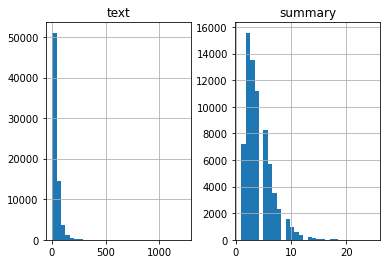

In [64]:
#Data Visualization
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

#Populating the lists with sentence lengths
for i in reviewsData['Cleaned_Text']:
      text_word_count.append(len(i.split()))

for i in reviewsData['Cleaned_Summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [65]:
#Function for getting the Maximum Review length  
count=0 
for i in reviewsData['Cleaned_Text']:
    if(len(i.split())<=35):
        count=count+1
print(count/len(reviewsData['Cleaned_Text']))

0.6227522267660075


In [66]:

#Function for getting the Maximum Summary length
count=0
for i in reviewsData['Cleaned_Summary']:
    if(len(i.split())<=8):
        count=count+1
print(count/len(reviewsData['Cleaned_Summary']))

0.9426642765111198


In [67]:
#From the above data we got an idea about maximum lengths of review and summary
max_text_len = 35
max_summary_len = 8

**getting rid of outliers**

In [68]:
#Adding START and END tags to summary for better decoding
cleaned_text =np.array(reviewsData['Cleaned_Text'])
cleaned_summary=np.array(reviewsData['Cleaned_Summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

**Adding tokens at the beginning and the end of summary**

In [69]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

**splitting traing and test set**

In [70]:
#Splitting the Dataset
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.2,random_state=0,shuffle=True)

**prepare a tokenizer for reviews on training data**

In [71]:
#Preparing Tokenizer

#Text Tokenizer
from keras.preprocessing.text import Tokenizer 
#from keras.preprocessing.sequence import pad_sequences
from keras_preprocessing.sequence import pad_sequences

#preparing a tokenizer for reviews on training data
X_tokenizer = Tokenizer() 
X_tokenizer.fit_on_texts(list(X_train))

**calculating number of rare and common words in reviews**

In [72]:
#Rarewords and their coverage in review
thresh = 4  #If a word whose count is less than threshold i.e 4, then it's considered as rare word 

cnt = 0      #denotes no. of rare words whose count falls below threshold
tot_cnt = 0  #denotes size of unique words in the text
freq = 0
tot_freq = 0

for key,value in X_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 65.40023077909312
Total Coverage of rare words: 3.108448329964315


**defining tokenizer with most common words for reviews**

In [73]:
#Defining the Tokenizer with top most common words for reviews

#Preparing a Tokenizer for reviews on training data
X_tokenizer = Tokenizer(num_words=tot_cnt-cnt)   #provides top most common words
X_tokenizer.fit_on_texts(list(X_train))

#Converting text sequences into integer sequences
X_train_seq    =   X_tokenizer.texts_to_sequences(X_train) 
X_test_seq   =   X_tokenizer.texts_to_sequences(X_test)

#Padding zero upto maximum length
X_train    =   pad_sequences(X_train_seq,  maxlen = max_text_len, padding = 'post')
X_test   =   pad_sequences(X_test_seq, maxlen = max_text_len, padding = 'post')

#Size of vocabulary (+1 for padding token)
X_voc   =  X_tokenizer.num_words + 1

In [74]:
X_voc 

8097

**prepare a tokenizer for summaries on training data**

In [75]:
#Summary Tokenizer

#Preparing a Tokenizer for summaries on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_train))

**calculating number of rare and common words in summaries**

In [76]:
#Rarewords and their coverage in summary

thresh = 6  ##If a word whose count is less than threshold i.e 6, then it's considered as rare word 

cnt = 0
tot_cnt = 0
freq = 0
tot_freq = 0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt = tot_cnt+1
    tot_freq = tot_freq+value
    if(value<thresh):
        cnt = cnt+1
        freq = freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 78.4256559766764
Total Coverage of rare words: 5.979851217436657


**defining tokenizer with most common words for summaries**

In [77]:
#Defining Tokenizer with the most common words in summary

#Preparing a tokenizer for summaries on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt)  #provides top most common words
y_tokenizer.fit_on_texts(list(y_train))

#Converting text sequences into integer sequences
y_train_seq    =   y_tokenizer.texts_to_sequences(y_train) 
y_test_seq   =   y_tokenizer.texts_to_sequences(y_test) 

#Padding zero upto maximum length
y_train    =   pad_sequences(y_train_seq, maxlen=max_summary_len, padding='post')
y_test   =   pad_sequences(y_test_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [78]:
y_voc

1777

**checking word count of start token is equal to length of the training data**

In [79]:
#Checking the length of training data
y_tokenizer.word_counts['sostok'],len(y_train)

(34459, 34459)

**deleting the rows that contain only START and END tokens**

In [80]:
#Deleting rows containing START and END tokens
#For Training set
ind=[]
for i in range(len(y_train)):
    cnt=0
    for j in y_train[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_train=np.delete(y_train,ind, axis=0)
X_train=np.delete(X_train,ind, axis=0)

In [81]:
#For Validation set
ind=[]
for i in range(len(y_test)):
    cnt=0
    for j in y_test[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_test=np.delete(y_test,ind, axis=0)
X_test=np.delete(X_test,ind, axis=0)

**Model building, defining LSTM layers, Encoder and Decoder**

In [86]:
from keras import backend as K 
import gensim
from numpy import *
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras_preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

K.clear_session()

latent_dim = 256
embedding_dim=256

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(X_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#dense layer - softmax
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 256)      2072832     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 35, 256),    525312      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

**MLNotify** is an open-source tool that notifies you when model training is complete via web, mobile, and email notifications – with just one import line.

In [87]:
import mlnotify

In [88]:
#Adding Metrics
model.compile(optimizer='rmsprop' , loss='sparse_categorical_crossentropy' , metrics=['accuracy'])

In [89]:
#Adding Callback
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [90]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [91]:
es = [EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2), 
      ModelCheckpoint('./MyModel_tf',monitor='val_loss', verbose=1,
                      save_best_only=True, mode='min', save_weights_only = False)]

**train the model**

In [92]:
#Training the Model

history = model.fit([X_train,y_train[:,:-1]],
                    y_train.reshape(y_train.shape[0],
                    y_train.shape[1], 1)[:,1:],
                    epochs=50,
                    batch_size= 512, 
                    validation_data=([X_test,y_test[:,:-1]], 
                    y_test.reshape(y_test.shape[0],
                    y_test.shape[1], 1)[:,1:]))

                                     
                                     
    █▀▀▀▀▀█ █  ▄▄ ▀▀▄ █▄  █▀▀▀▀▀█    
    █ ███ █ ██▄ █▄▀▄▄▀▀▄  █ ███ █    
    █ ▀▀▀ █ ▄██ ▀▀▄▀▀█▀▄▄ █ ▀▀▀ █    
    ▀▀▀▀▀▀▀ ▀ █▄▀ ▀ ▀▄▀▄▀ ▀▀▀▀▀▀▀    
    ▀█  █▀▀▄  ▀ ▀▄▀█▄▀▄▀ ▄▄█▄████    
    █▄▀▄▀ ▀▀▄█▀ ▄  █▄▄▄▄█▄█ █▄ ▄█    
      ▀ ▄ ▀▄█▄▄▀▄▄▀█▄█▄ ▀▀▄▄▄▄▄█▄    
     ▀▄█▀▀▀█▀  █▀▀ ▀▀▄█  ▀▄▀█▀▀▄█    
    ▄▄▀▄▀▀▀ ▄▄▄ ▀▄▀█▄█▄▀ ▀▄▄▄▄ █▄    
      ███▄▀█    ▄▀ █▄██ ▀▄▀▀▄ ▀▄█    
    ▀▀ ▀  ▀▀██▀▀▄▄▀█▄████▀▀▀█▀  █    
    █▀▀▀▀▀█ ▄▄██▀▀▀█▄▄███ ▀ █▀▀ ▀    
    █ ███ █ ▀▀  ▀▄▀▄▄▀ █▀█▀▀▀▀  █    
    █ ▀▀▀ █ ▄▀▄ ▄▀█▀██▀▀█▄   █▀██    
    ▀▀▀▀▀▀▀ ▀▀▀▀▀▀▀ ▀▀ ▀▀▀ ▀ ▀ ▀     
                                     
                                     
https://mlnotify.aporia.com/training/202267

Scan the QR code or enter the url to get a notification when your training is done


Epoch 1/50
66/66 [==============================] - 44s 487ms/step - loss: 3.2668 - accuracy: 0.5128 - val_loss: 2.7433 - val_accuracy: 0.5897
Epoch

In [102]:
%cd /content/drive/MyDrive/projects/Text_Summarization_Minor_Project/model1/fitted_model

/content/drive/MyDrive/projects/Text_Summarization_Minor_Project/model1/fitted_model


In [94]:
from keras.models import load_model

In [95]:
model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'

In [96]:
model = load_model('my_model.h5')

**convert the index to word for summaries and reviews vocabulary**

In [97]:
#Building Dictionary for Source Vocabulary
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=X_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

Inference

Set up the inference for the encoder and decoder

In [98]:
# Encoding our input seq for feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

dec_emb2= dec_emb_layer(decoder_inputs) 

# initial states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# softmax for probability
decoder_outputs2 = decoder_dense(decoder_outputs2) 

decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

**Defining a functio for implementation of the inference process**

In [99]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

**converting an integer sequence to a word sequence for summaries and reviews**

In [100]:
def sequence_to_summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def sequence_to_text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [105]:
inp_review = input("Enter : ")
print("Review :",inp_review)
#inp_review = clean(inp_review,"inputs")
inp_review = ' '.join(inp_review)
inp_x= X_tokenizer.texts_to_sequences([inp_review]) 
inp_x= pad_sequences(inp_x,  maxlen= max_text_len, padding='post')
 
summary=decode_sequence(inp_x.reshape(1,max_text_len))
if 'eos' in summary :
  summary=summary.replace('eos','')
print("\nPredicted summary:",summary);print("\n")

Enter : fries best low fat calorie great tasting lost pounds eating snack pieces equal serving hardly fat would recommend 
Review : fries best low fat calorie great tasting lost pounds eating snack pieces equal serving hardly fat would recommend 
1/1 [==============================] - 0s 15ms/step

Predicted summary:  good stuff




Predict and print summaries from model


In [104]:
#Summaries generated by the model

for i in range(0,20):
    print("Review:",sequence_to_text(X_train[i]))
    print("Original summary:",sequence_to_summary(y_train[i]))
    print("Predicted summary:",decode_sequence(X_train[i].reshape(1,max_text_len)))
    print("\n")

Review: since discovering yogi teas years ago enjoyed rich aroma tastes varied flavors well fact de caf love peach tea general definitely favorite peach flavor herbal tea companies yogi vanilla almond also basket tea drink everyday 
Original summary: another great yogi tea 
1/1 [==============================] - 0s 18ms/step
Predicted summary:  best tea ever


Review: pork rind lover awesome product wonderful taste buds melt mouth go mmm mmm good 
Original summary: delicious for those taste buds 
1/1 [==============================] - 0s 16ms/step
Predicted summary:  great for low carb diets


Review: chocolate coffees tried chocolate aroma taste really enjoy chocolate aroma dripping delivers chocolate creamy taste associate chocolate glazed donut 
Original summary: real chocolate 
1/1 [==============================] - 0s 91ms/step
Predicted summary:  chocolate is the best


Review: bought day canada delish available states would buy 
Original summary: yum 
1/1 [======================